In [2]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
from plot_map import plot_map
import math
plt.rcParams['font.sans-serif']=['Arial Unicode MS']
plt.rcParams['axes.unicode_minus']=False

In [3]:
def reverse_bearing(x):
    return x + 180 if x < 180 else x - 180

In [4]:
def count_and_merge(n, bearings):
    # make twice as many bins as desired, then merge them in pairs
    # prevents bin-edge effects around common values like 0° and 90°
    n = n * 2
    bins = np.arange(n + 1) * 360 / n
    count, _ = np.histogram(np.array(bearings), bins=bins)
    
    # move the last bin to the front, so eg 0.01° and 359.99° will be binned together
    count = np.roll(count, 1)
    return count[::2] + count[1::2]

In [5]:
def calculate_entropy(count):
    count_p = count/count.sum()
    entropy = 0
    for i in count_p:
        entropy -= i*math.log(i)
    return entropy 

In [6]:
# function to draw a polar histogram for a set of edge bearings
def polar_plot(ax, bearings, n=36, title=''):

    bins = np.arange(n + 1) * 360 / n
    count = count_and_merge(n, bearings)
    _, division = np.histogram(bearings, bins=bins)
    frequency = count / count.sum()
    division = division[0:-1]
    width =  2 * np.pi / n

    ax.set_theta_zero_location('N')
    ax.set_theta_direction('clockwise')

    x = division * np.pi / 180
    bars = ax.bar(x, height=frequency, width=width, align='center', bottom=0, zorder=2,
                  color='#003366', edgecolor='k', linewidth=0.5, alpha=0.7)
    
    ax.set_ylim(top=frequency.max())
    
    title_font = {'family':'DejaVu Sans', 'size':24, 'weight':'bold'}
    xtick_font = {'family':'DejaVu Sans', 'size':10, 'weight':'bold', 'alpha':1.0, 'zorder':3}
    ytick_font = {'family':'DejaVu Sans', 'size': 9, 'weight':'bold', 'alpha':0.2, 'zorder':3}
    
    ax.set_title(title.upper(), y=1.05, fontdict=title_font)
    
    ax.set_yticks(np.linspace(0, max(ax.get_ylim()), 5))
    yticklabels = ['{:.2f}'.format(y) for y in ax.get_yticks()]
    yticklabels[0] = ''
    ax.set_yticklabels(labels=yticklabels, fontdict=ytick_font)
    
    xticklabels = ['N', '', 'E', '', 'S', '', 'W', '']
    ax.set_xticklabels(labels=xticklabels, fontdict=xtick_font)
    ax.tick_params(axis='x', which='major', pad=-2)

In [383]:
sh = gpd.read_file('./上海行政区/区县界_area.shp')

In [451]:
road = gpd.GeoDataFrame(columns = ['u', 'v', 'key', 'osmid', 'name', 'highway', 'oneway', 'length',
       'geometry', 'bridge', 'ref', 'lanes', 'maxspeed', 'access', 'tunnel',
       'junction','district'])
orientation_count = []
for i in sh.index:
    
    G = ox.graph_from_polygon(sh.loc[i,'geometry'],network_type='drive')
    #sh.loc[i,'三岔路口比例'] = ox.stats.basic_stats(G)['streets_per_node_proportion'][3]
    #sh.loc[i,'十字路口比例'] = ox.stats.basic_stats(G)['streets_per_node_proportion'][4]
    
    road_gdf = ox.graph_to_gdfs(G)[1]
    road_gdf['district'] = sh.loc[i,'NAME']
    road = road.append(road_gdf,ignore_index=True)
    
    Gu = ox.add_edge_bearings(ox.get_undirected(G))
    b = pd.Series([d['bearing'] for u, v, k, d in Gu.edges(keys=True, data=True)])
    b = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop=True).dropna()
    orientation_count.append(b)
    
    sh.loc[i,'方向熵'] = calculate_entropy(count_and_merge(36,b))
    
    print('{}处理完毕'.format(sh.loc[i,'NAME']))

宝山区处理完毕
杨浦区处理完毕
闵行区处理完毕
普陀区处理完毕
松江区处理完毕
虹口区处理完毕
闸北区处理完毕
长宁区处理完毕
徐汇区处理完毕
静安区处理完毕
黄浦区处理完毕
金山区处理完毕
崇明县处理完毕
奉贤区处理完毕
嘉定区处理完毕
青浦区处理完毕
浦东新区处理完毕


In [452]:
district_entropy = sh.loc[:,['NAME','方向熵']]

In [453]:
district_entropy.columns = ['district','方向熵']

In [454]:
road = pd.merge(road,district_entropy,on='district',how='outer')

In [455]:
bounds = [120.79560279980944,30.623112899720564,122.03020320013769, 31.925845100091397]

imgsavepath do not exist, your tile map will not save


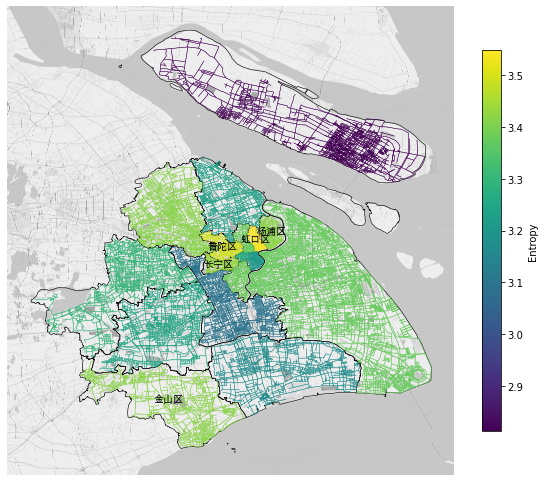

In [528]:
base = sh.plot(figsize=(10,10),facecolor='none',edgecolor='black',lw=0.6)
road.plot(ax=base,column='方向熵',lw=0.4,legend=True,legend_kwds={'shrink':0.7,'label':'Entropy'})
for i in sh.index:
    if sh.loc[i,'方向熵'] >= sh['方向熵'].quantile(0.75):
        plt.text(sh.loc[i,'geometry'].centroid.x,sh.loc[i,'geometry'].centroid.y,sh.loc[i,'NAME'],fontdict={'family':'Arial Unicode MS','size':10},horizontalalignment='center',verticalalignment='center')
plot_map(plt,bounds,zoom=14,style=4)
base.axis('off')
plt.savefig('sh_entropy_plot.jpg',dpi=300,bbox_inches='tight')
plt.show()

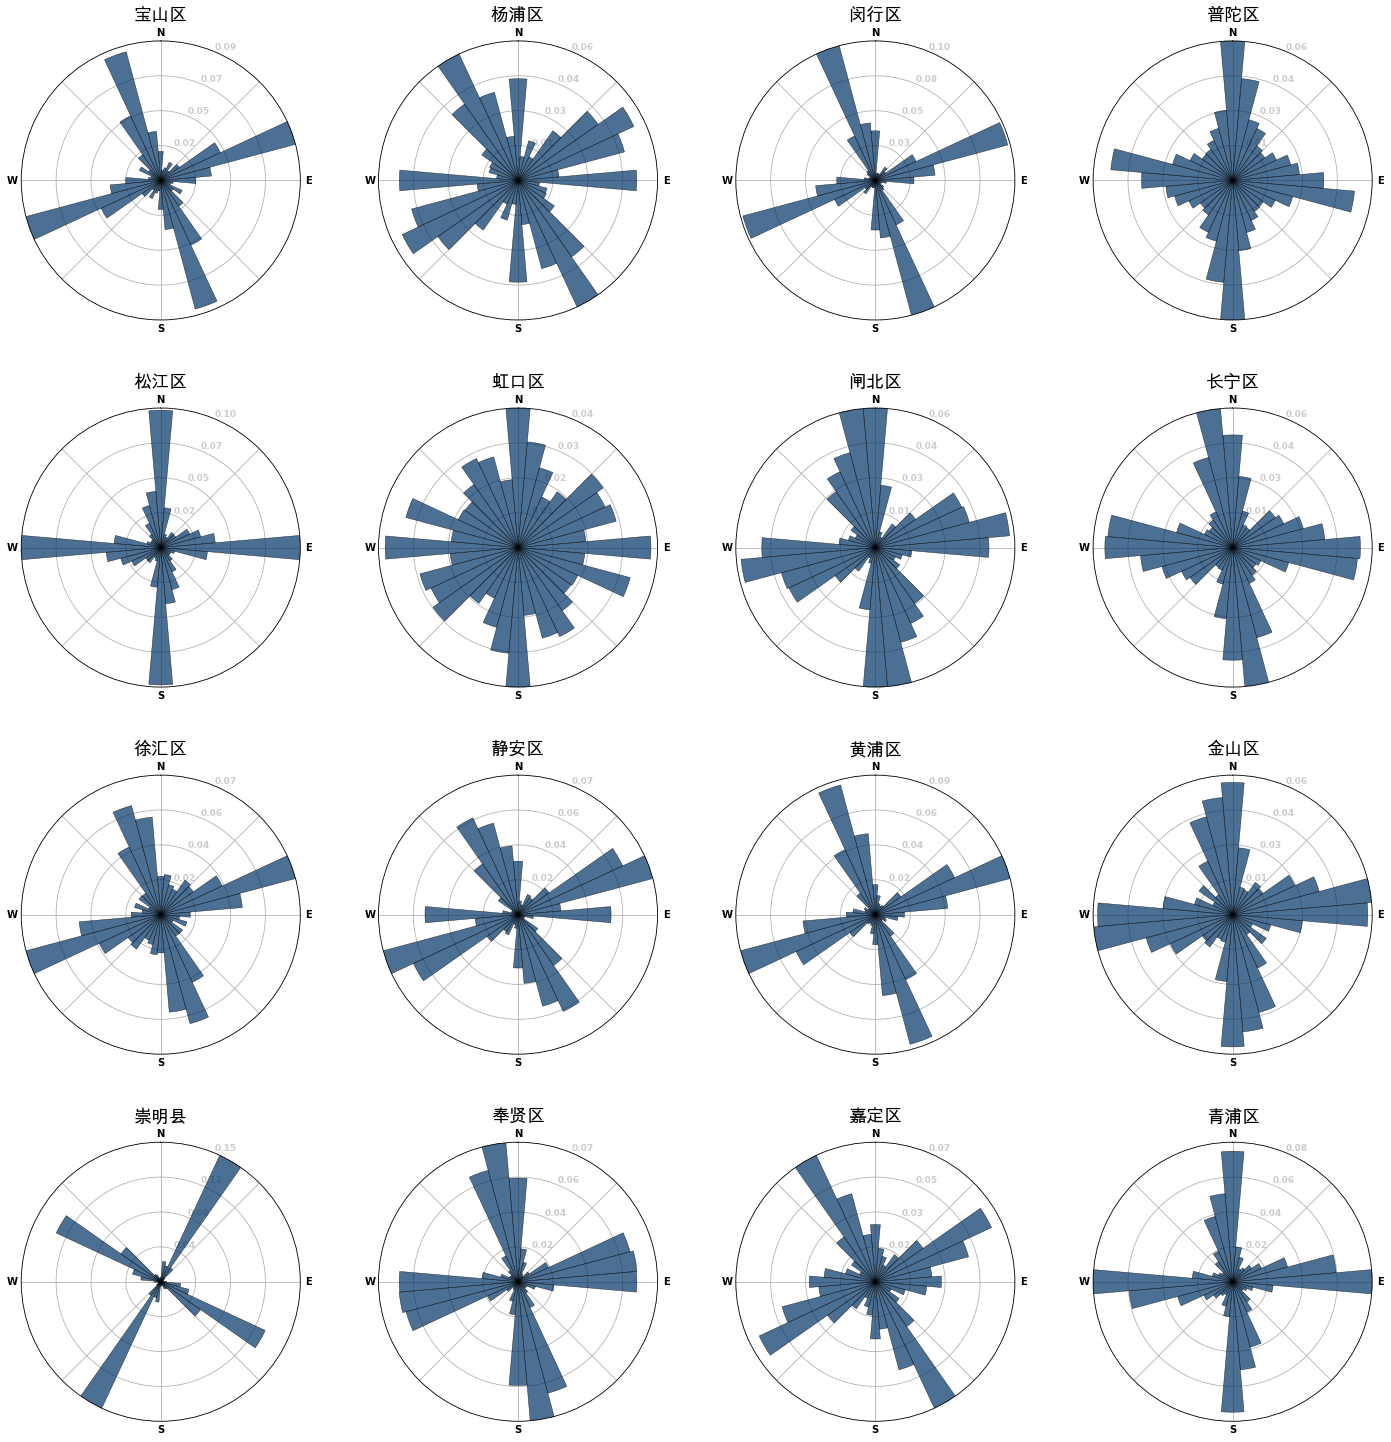

In [529]:
fig, axes = plt.subplots(4,4, figsize=(20,20),subplot_kw={'projection':'polar'})
fig.tight_layout(h_pad=5)
for i in range(4):
    for x in range(4):
        polar_plot(axes[i][x],orientation_count[i*4+x])
        axes[i][x].set_title(sh.loc[i*4+x,'NAME'],fontdict={'family':'Arial Unicode MS','weight':'heavy','size':18})
plt.savefig('sh_street_orientation.jpg',dpi=300,bbox_inches='tight')

In [7]:
cq = gpd.read_file('./重庆市/区县界_area.shp')

In [9]:
cq = cq.iloc[[13,14,15,26,31,32,33,34,35],:]

In [27]:
cq.reset_index(drop=True,inplace=True)

In [15]:
road = gpd.GeoDataFrame(columns = ['u', 'v', 'key', 'osmid', 'name', 'highway', 'oneway', 'length',
       'geometry', 'bridge', 'ref', 'lanes', 'maxspeed', 'access', 'tunnel',
       'junction','district'])
orientation_count = []
for i in cq.index:
    
    G = ox.graph_from_polygon(cq.loc[i,'geometry'],network_type='drive')
    #cq.loc[i,'三岔路口比例'] = ox.stats.basic_stats(G)['streets_per_node_proportion'][3]
    #cq.loc[i,'十字路口比例'] = ox.stats.basic_stats(G)['streets_per_node_proportion'][4]
    
    road_gdf = ox.graph_to_gdfs(G)[1]
    road_gdf['district'] = cq.loc[i,'NAME']
    road = road.append(road_gdf,ignore_index=True)
    
    Gu = ox.add_edge_bearings(ox.get_undirected(G))
    b = pd.Series([d['bearing'] for u, v, k, d in Gu.edges(keys=True, data=True)])
    b = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop=True).dropna()
    orientation_count.append(b)
    
    cq.loc[i,'方向熵'] = calculate_entropy(count_and_merge(36,b))
    
    print('{}处理完毕'.format(cq.loc[i,'NAME']))

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


渝北区处理完毕


/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


北碚区处理完毕


/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


沙坪坝区处理完毕


/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


巴南区处理完毕


/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


江北区处理完毕


/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


九龙坡区处理完毕


/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


南岸区处理完毕


/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


渝中区处理完毕
大渡口区处理完毕


/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [17]:
district_entropy = cq.loc[:,['NAME','方向熵']]

In [18]:
district_entropy.columns = ['district','方向熵']

In [19]:
road = pd.merge(road,district_entropy,on='district',how='outer')

In [20]:
bounds = [106.20977790026993,29.079847999725487,107.03557209963279, 30.17672399987273]

imgsavepath do not exist, your tile map will not save


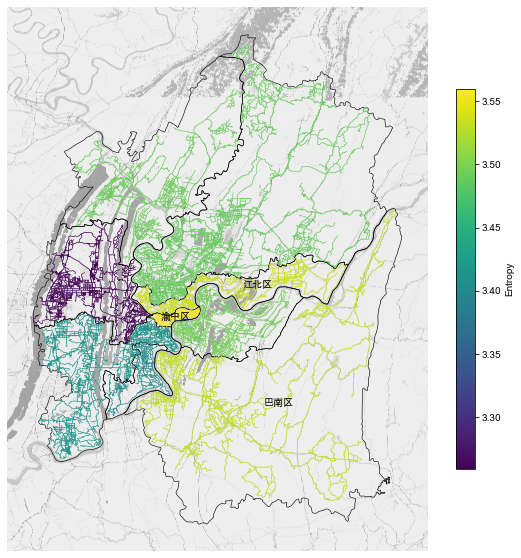

In [22]:
base = cq.plot(figsize=(10,10),facecolor='none',edgecolor='black',lw=0.6)
road.plot(ax=base,column='方向熵',lw=0.4,legend=True,legend_kwds={'shrink':0.7,'label':'Entropy'})
for i in cq.index:
    if cq.loc[i,'方向熵'] >= cq['方向熵'].quantile(0.75):
        plt.text(cq.loc[i,'geometry'].centroid.x,cq.loc[i,'geometry'].centroid.y,cq.loc[i,'NAME'],fontdict={'family':'Arial Unicode MS','size':10},horizontalalignment='center',verticalalignment='center')
plot_map(plt,bounds,zoom=14,style=4)
base.axis('off')
plt.savefig('cq_entropy_plot.jpg',dpi=300,bbox_inches='tight')
plt.show()

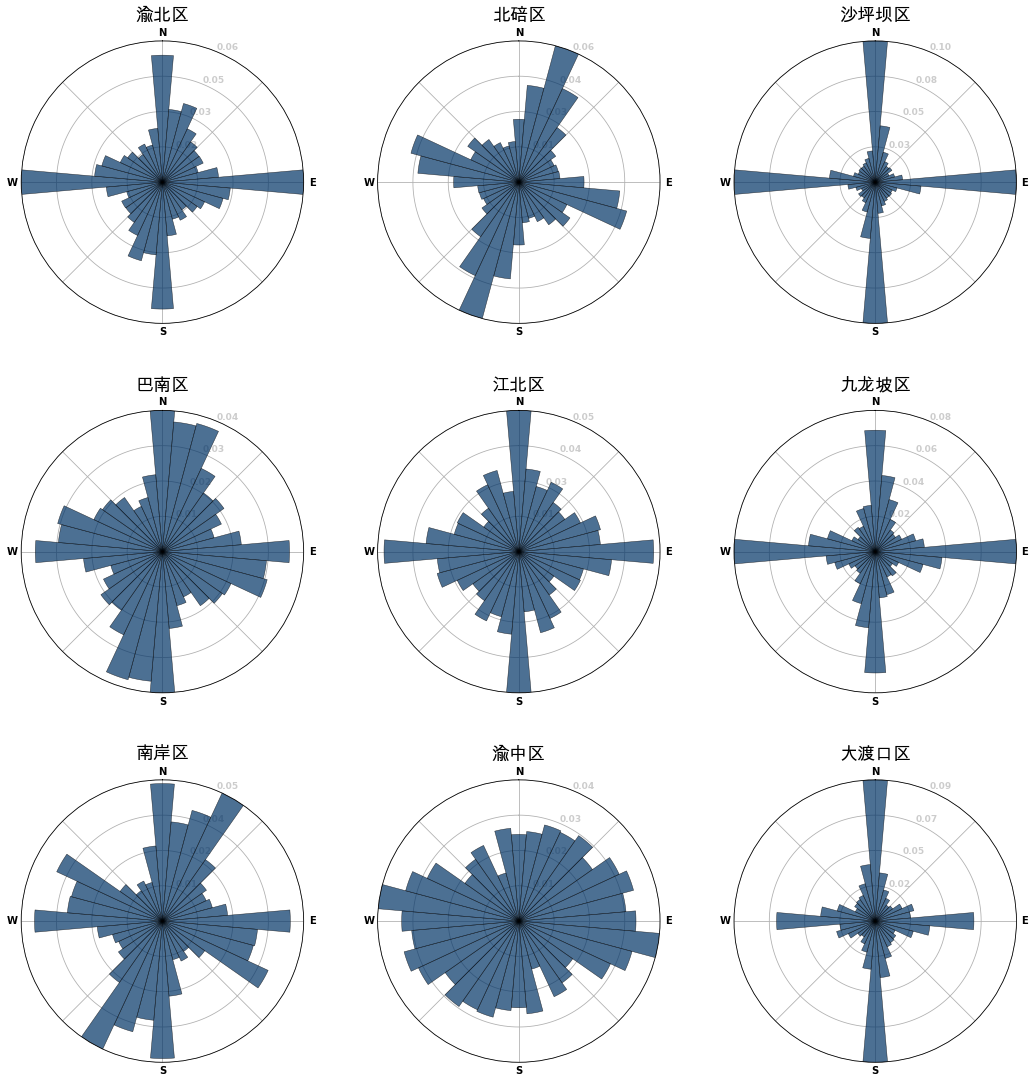

In [28]:
fig, axes = plt.subplots(3,3, figsize=(15,15),subplot_kw={'projection':'polar'})
fig.tight_layout(h_pad=5)
for i in range(3):
    for x in range(3):
        polar_plot(axes[i][x],orientation_count[i*3+x])
        axes[i][x].set_title(cq.loc[i*3+x,'NAME'],fontdict={'family':'Arial Unicode MS','weight':'heavy','size':18})
plt.savefig('cq_street_orientation.jpg',dpi=300,bbox_inches='tight')